<a href="https://colab.research.google.com/github/adv555/DataScience/blob/main/PySpark/pyspark_hw_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

# Task 1

В этом задании вам потребуется скачать вот этот [датасет](https://www.kaggle.com/datasets/sootersaalu/amazon-top-50-bestselling-books-2009-2019?resource=download). Это все так же Топ-50 самых продаваемых книг на Amazon в период с 2009 по 2019 годы. 

**Требуется выполнить следующее:**
* Создать спарк сессию.
* Прочитать датасет в датафрейм.
* Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7
* Построить гистограмму распределения рецензий (столбец Reviews).
* Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".
* Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price".

In [143]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col, desc, count, mean, avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from pyspark.sql.types import DoubleType

In [10]:
url = 'https://drive.google.com/file/d/1_8345ql1MxCyNnNjcFOn19BwreaoRuf9/view?usp=share_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
# dwn_url="/content/bestsellers with categories.csv"

In [11]:
spark_session = SparkSession.builder.getOrCreate()
authors_df = spark_session.read.options(header=True).csv(dwn_url)

for col in authors_df.columns:
    authors_df = authors_df.withColumnRenamed(col, col.lower())

authors_df.printSchema()
authors_df.show()

root
 |-- name: string (nullable = true)
 |-- author: string (nullable = true)
 |-- user rating: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genre: string (nullable = true)

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                name|              author|user rating|reviews|price|year|      genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R.

In [12]:
type(authors_df)

pyspark.sql.dataframe.DataFrame

In [13]:
# Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7

authors_df.filter(authors_df['user rating'] > 4.7).select(mean("price").alias("average price")).show()

+-----------------+
|    average price|
+-----------------+
|10.69832402234637|
+-----------------+



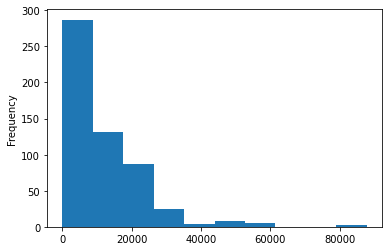

In [14]:
# Построить гистограмму распределения рецензий (столбец Reviews).

pandas_frame = authors_df.toPandas()

pandas_frame['reviews'].astype(float).plot(kind='hist');


In [15]:
# Version 1. Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [43]:
authors_df.dtypes
authors_df = authors_df.withColumn("user rating",authors_df['user rating'].cast('float'))
authors_df = authors_df.withColumn("reviews",authors_df.reviews.cast('float'))
authors_df = authors_df.withColumn("price",authors_df.price.cast('float'))
# authors_df = authors_df.withColumn("price",authors_df.price.cast(DoubleType()))
authors_df.printSchema()

# authors_df.select(["user rating","reviews", "price"]).corr("user rating","reviews")
# authors_df.select(["user rating","reviews", "price"]).corr("reviews", "price")
# authors_df.select(["user rating","reviews", "price"]).corr("user rating", "price")


root
 |-- name: string (nullable = true)
 |-- author: string (nullable = true)
 |-- user rating: float (nullable = true)
 |-- reviews: float (nullable = true)
 |-- price: float (nullable = true)
 |-- year: string (nullable = true)
 |-- genre: string (nullable = true)



In [19]:
new_df = authors_df.select(["user rating","reviews", "price"])

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=new_df.columns, outputCol=vector_col)
df_vector = assembler.transform(new_df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
matrix

DenseMatrix(3, 3, [1.0, -0.0017, -0.1331, -0.0017, 1.0, -0.1092, -0.1331, -0.1092, 1.0], False)

In [20]:
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=["user rating","reviews", "price"]) 
corr_matrix_df.style.background_gradient(axis=0, gmap=corr_matrix_df['user rating'], cmap='YlOrRd')

,user rating,reviews,price
0,1.000000,-0.001729,-0.133086
1,-0.001729,1.000000,-0.109182
2,-0.133086,-0.109182,1.000000


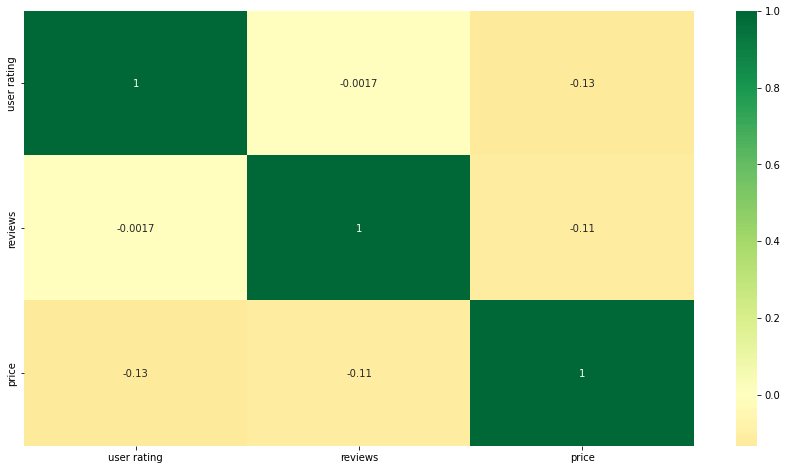

In [22]:
# Version 2. Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".
plt.figure(figsize=(15, 8))
data_for_corr = authors_df.select(['user rating','reviews','price']).toPandas()
data_for_corr = data_for_corr[['user rating','reviews','price']].astype(float)
sns.heatmap(data_for_corr.corr(), xticklabels=data_for_corr.corr().columns, yticklabels=data_for_corr.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.show()

In [23]:
# version 3
# creation of DataFrame
df = pd.DataFrame(data_for_corr)
 
# creation of correlation matrix
corrM = df.corr()
 
corrM.style.background_gradient(axis=0,  cmap='YlOrRd')  

,user rating,reviews,price
user rating,1.000000,-0.001729,-0.133086
reviews,-0.001729,1.000000,-0.109182
price,-0.133086,-0.109182,1.000000


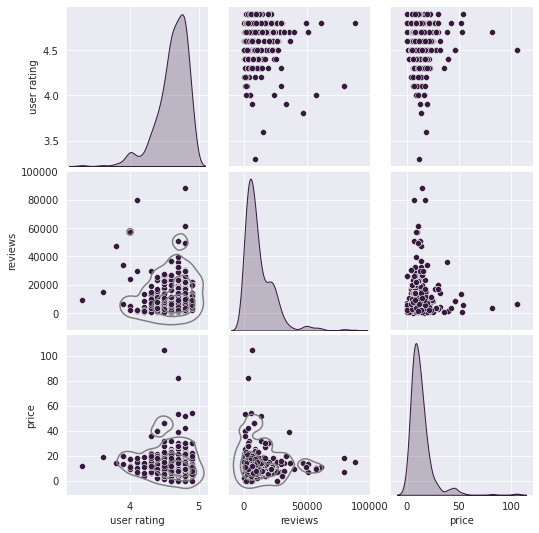

In [96]:
# Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price".

sns.set_style('darkgrid')
sns.set_palette("rocket")

g = sns.pairplot(data_for_corr, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color="0.5");

# Task 2

При выполнении этого задания разрешается использовать только **Spark SQL**

**Для датасета из предыдущего задания выполните следующее:**

* Найдите автора с самым высоким рейтингом.
* Найдите трех авторов с самым низким рейтингом.
* Определите какой автор получил наибольшее количество рецензий.
* Определите какой автор написал наибольшее количество книг за весь доступный в данных период.
* Определите какая книга жанра **"Fiction"** имеет самый маленький рейтинг.
* Определите какая книга жанра **"Non Fiction"** имеет самый высокий рейтинг.

In [87]:
from pyspark.sql.functions import sum, col, desc, count

In [29]:
# Найдите автора с самым высоким рейтингом.
authors_df.sort(authors_df["user rating"].desc()).show(1)

+--------------------+---------------+-----------+-------+-----+----+-------+
|                name|         author|user rating|reviews|price|year|  genre|
+--------------------+---------------+-----------+-------+-----+----+-------+
|Brown Bear, Brown...|Bill Martin Jr.|        4.9|14344.0|  5.0|2017|Fiction|
+--------------------+---------------+-----------+-------+-----+----+-------+
only showing top 1 row



In [31]:
# Найдите трех авторов с самым низким рейтингом.
authors_df.sort(authors_df["user rating"].asc()).show(3)

+--------------------+------------+-----------+-------+-----+----+-------+
|                name|      author|user rating|reviews|price|year|  genre|
+--------------------+------------+-----------+-------+-----+----+-------+
|  The Casual Vacancy|J.K. Rowling|        3.3| 9372.0| 12.0|2012|Fiction|
|Go Set a Watchman...|  Harper Lee|        3.6|14982.0| 19.0|2015|Fiction|
|Fifty Shades of G...|   E L James|        3.8|47265.0| 14.0|2012|Fiction|
+--------------------+------------+-----------+-------+-----+----+-------+
only showing top 3 rows



In [83]:
# Определите какой автор получил наибольшее количество рецензий.

authors_df.groupBy('author').agg(sum('reviews').alias('total reviews')).sort(desc('total reviews')).show(1)

+---------------+-------------+
|         author|total reviews|
+---------------+-------------+
|Suzanne Collins|     278329.0|
+---------------+-------------+
only showing top 1 row



In [89]:
# Определите какой автор написал наибольшее количество книг за весь доступный в данных период.

authors_df.groupBy('author').agg(count('name').alias('total books')).sort(desc('total books')).show(1)

+-----------+-----------+
|     author|total books|
+-----------+-----------+
|Jeff Kinney|         12|
+-----------+-----------+
only showing top 1 row



In [149]:
authors_df.show(1)

+--------------------+--------+-----------+-------+-----+----+-----------+
|                name|  author|user rating|reviews|price|year|      genre|
+--------------------+--------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|JJ Smith|        4.7|17350.0|  8.0|2016|Non Fiction|
+--------------------+--------+-----------+-------+-----+----+-----------+
only showing top 1 row



In [110]:
# Определите какая книга жанра "Fiction" имеет самый маленький рейтинг.

authors_df.select(['name', 'user rating', 'genre'])\
.filter(authors_df.genre == 'Fiction')\
.sort(authors_df['user rating']).show(1)

+------------------+-----------+-------+
|              name|user rating|  genre|
+------------------+-----------+-------+
|The Casual Vacancy|        3.3|Fiction|
+------------------+-----------+-------+
only showing top 1 row



In [112]:
# Определите какая книга жанра "Non Fiction" имеет самый высокий рейтинг.

authors_df.select(['name', 'user rating', 'genre'])\
.filter(authors_df.genre == 'Non Fiction')\
.sort(desc(authors_df['user rating'])).show(1)

+--------------------+-----------+-----------+
|                name|user rating|      genre|
+--------------------+-----------+-----------+
|Hamilton: The Rev...|        4.9|Non Fiction|
+--------------------+-----------+-----------+
only showing top 1 row



# Task 3

* Постройте гистограмму среднего количества рецензий по годам. 
* В виде отдельной гистограммы визуализируйте количество книг жанра **"Fiction"** и **"Non Fiction"** за весь доступный период.

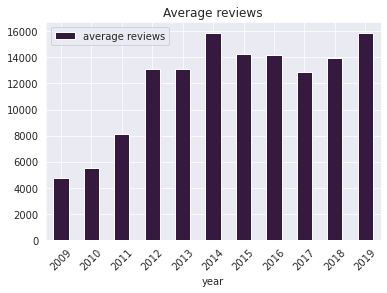

In [172]:
# Постройте гистограмму среднего количества рецензий по годам.

avg_reviews = authors_df.groupBy('year').agg(avg('reviews').alias('average reviews')).sort('year')
avg_reviews.toPandas().plot(x='year', y='average reviews', kind='bar');

plt.xticks(rotation=45)
plt.title("Average reviews")
plt.show()

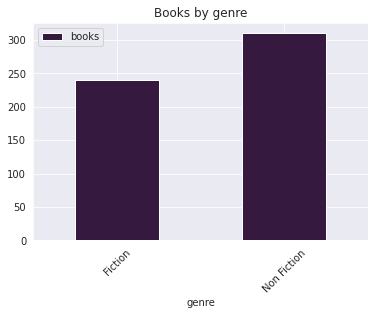

In [167]:
# В виде отдельной гистограммы визуализируйте количество книг жанра "Fiction" и "Non Fiction" за весь доступный период.
books_by_genre = authors_df.groupBy('genre').agg(count('name').alias('books'))
books_by_genre.toPandas().plot(x='genre', y='books', kind='bar');

plt.xticks(rotation=45)
plt.title("Books by genre")
plt.show()